In [9]:
# BMED Free Running Simulator
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("🎯 BMED 1stage optimizer")
print("="*60)

🎯 BMED 1stage optimizer


In [10]:
# Model Classes (same as reference)

class LayerNormLSTM(nn.Module):
    """LSTM layer with layer normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4 * hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_h = nn.LayerNorm(hidden_node)
        self.ln_g = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)

        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_g, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_g, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_h(i_f + h_f))
        g_g = torch.tanh(self.ln_g(i_g + h_g))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))

        c_new = f_g * c_prev + i_g * g_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new

class StateExtr(nn.Module):
    """State Extractor using LayerNorm LSTM"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for _ in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, input_node = x.size()
        device = x.device

        h_states = []
        c_states = []
        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))

                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)
        
        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

class PhysicalChangeDecoder(nn.Module):
    """Physical Change Decoder"""
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Linear(hidden_node, output_node))
    
    def forward(self, hidden_states):
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

class CurrentPredictor(nn.Module):
    """Current Predictor"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))
        
        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
        
        self.layers.append(nn.Linear(hidden_node, 1))
    
    def forward(self, new_state):
        x = new_state
        for layer in self.layers:
            x = layer(x)
        return x

print("✅ 모델 클래스 정의 완료")

✅ 모델 클래스 정의 완료


In [11]:
class PhysicsConstraintLayer(nn.Module):
    """Physics Constraint Layer with CSTR Flow-in/Discharge Logic"""
    def __init__(self, range_mm, current_predictor, eps=1e-2):
        super().__init__()
        self.sps = eps
        self.current_predictor = current_predictor
        self.register_buffer('range_mm_tensor', self._convert_range_to_tensor(range_mm))

    def _convert_range_to_tensor(self, range_mm):
        feature_names = ['V','E','VF','VA','VB','CFLA','CALA','CFK','CBK','I']
        ranges = torch.zeros(len(feature_names),2)

        for i, name in enumerate(feature_names):
            if name in range_mm:
                ranges[i, 0] = range_mm[name]['min']
                ranges[i, 1] = range_mm[name]['max']
        
        return ranges
    
    def normalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def denormalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return data * (max_val - min_val) + min_val

    def forward(self, physical_changes, current_state, flow_in, initial_volumes):
        """
        Args:
            physical_changes: [batch, seq, 4] - [dVA, dVB, rratio, dNBK]
            current_state: [batch, seq, 10] - normalized state
            flow_in: [5] - [Feed_flow, Acid_flow, Base_flow, Feed_LA_conc, Feed_K_conc]
            initial_volumes: [3] - [VF_init, VA_init, VB_init] - target volumes
        Returns:
            next_state: [batch, seq, 10] - normalized next state
            discharge: dict - discharge information for each channel
        """
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        # Current state denormalization
        VF = self.denormalize(current_state[..., 2:3], VF_idx)
        VA = self.denormalize(current_state[..., 3:4], VA_idx)
        VB = self.denormalize(current_state[..., 4:5], VB_idx)
        CFLA = self.denormalize(current_state[..., 5:6], CFLA_idx)
        CALA = self.denormalize(current_state[..., 6:7], CALA_idx)
        CFK = self.denormalize(current_state[..., 7:8], CFK_idx)
        CBK = self.denormalize(current_state[..., 8:9], CBK_idx)

        # Flow_in parameters
        F_feed, F_acid, F_base, C_feed_LA, C_feed_K = flow_in
        VF_target, VA_target, VB_target = initial_volumes

        # CSTR Flow-in additions per time step
        dVF_in = F_feed  # L/time_step
        dVA_in = F_acid  # L/time_step  
        dVB_in = F_base  # L/time_step
        dNFLA_in = F_feed * C_feed_LA  # mol/time_step
        dNFK_in = F_feed * C_feed_K    # mol/time_step

        # Physical changes from model
        dVA = physical_changes[..., 0:1]
        dVB = physical_changes[..., 1:2]
        rratio = physical_changes[..., 2:3]
        dNBK = physical_changes[..., 3:4]

        ratio = torch.sigmoid(rratio)
        dNALA = ratio * dNBK
        
        # Current mole amounts
        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        # Physics constraints for electrochemical changes
        condition1 = VF < dVA + dVB
        dVA = torch.where(condition1, torch.zeros_like(dVA), dVA)
        dVB = torch.where(condition1, torch.zeros_like(dVB), dVB)
        
        condition2 = NFLA < dNALA
        dNALA = torch.where(condition2, torch.zeros_like(dNALA), dNALA)
        
        condition3 = NFK < dNBK
        dNBK = torch.where(condition3, torch.zeros_like(dNBK), dNBK)

        # Volume changes: electrochemical + flow-in
        nVF_before_discharge = VF - dVA - dVB + dVF_in
        nVA_before_discharge = VA + dVA + dVA_in
        nVB_before_discharge = VB + dVB + dVB_in

        # Mole changes: electrochemical + flow-in
        nNFLA_before_discharge = NFLA - dNALA + dNFLA_in
        nNALA_after_transfer = NALA + dNALA
        nNFK_before_discharge = NFK - dNBK + dNFK_in
        nNBK_after_transfer = NBK + dNBK

        # Calculate discharges when volumes exceed targets
        discharge_VF = torch.clamp(nVF_before_discharge - VF_target, min=0.0)
        discharge_VA = torch.clamp(nVA_before_discharge - VA_target, min=0.0)
        discharge_VB = torch.clamp(nVB_before_discharge - VB_target, min=0.0)

        # Final volumes after discharge
        nVF = nVF_before_discharge - discharge_VF
        nVA = nVA_before_discharge - discharge_VA
        nVB = nVB_before_discharge - discharge_VB

        # Ensure minimum volumes
        nVF = torch.clamp(nVF, min=self.sps)
        nVA = torch.clamp(nVA, min=self.sps)
        nVB = torch.clamp(nVB, min=self.sps)

        # Discharge compositions (concentration-based discharge)
        if nVF_before_discharge > self.sps:
            discharge_fraction_F = discharge_VF / nVF_before_discharge
            discharge_NFLA = nNFLA_before_discharge * discharge_fraction_F
            discharge_NFK = nNFK_before_discharge * discharge_fraction_F
        else:
            discharge_NFLA = torch.zeros_like(discharge_VF)
            discharge_NFK = torch.zeros_like(discharge_VF)

        if nVA_before_discharge > self.sps:
            discharge_fraction_A = discharge_VA / nVA_before_discharge
            discharge_NALA = nNALA_after_transfer * discharge_fraction_A
        else:
            discharge_NALA = torch.zeros_like(discharge_VA)

        if nVB_before_discharge > self.sps:
            discharge_fraction_B = discharge_VB / nVB_before_discharge
            discharge_NBK = nNBK_after_transfer * discharge_fraction_B
        else:
            discharge_NBK = torch.zeros_like(discharge_VB)

        # Final mole amounts after discharge
        nNFLA = nNFLA_before_discharge - discharge_NFLA
        nNALA = nNALA_after_transfer - discharge_NALA
        nNFK = nNFK_before_discharge - discharge_NFK
        nNBK = nNBK_after_transfer - discharge_NBK

        # Final concentrations
        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB

        # Unchanged parameters
        V = current_state[..., 0:1]
        E = current_state[..., 1:2]
        
        # Normalize for model compatibility
        nVF_norm = self.normalize(nVF, VF_idx)
        nVA_norm = self.normalize(nVA, VA_idx)
        nVB_norm = self.normalize(nVB, VB_idx)
        nCFLA_norm = self.normalize(nCFLA, CFLA_idx)
        nCALA_norm = self.normalize(nCALA, CALA_idx)
        nCFK_norm = self.normalize(nCFK, CFK_idx)
        nCBK_norm = self.normalize(nCBK, CBK_idx)

        # Predict current
        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)
        
        nI_pred_norm = self.current_predictor(temp_state)
        nI_real = self.denormalize(nI_pred_norm, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self.normalize(nI_real, I_idx)

        # Final next state
        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)
        
        # Discharge information
        discharge_info = {
            'VF': discharge_VF,
            'VA': discharge_VA, 
            'VB': discharge_VB,
            'NFLA': discharge_NFLA,
            'NALA': discharge_NALA,
            'NFK': discharge_NFK,
            'NBK': discharge_NBK,
            'CFLA': torch.where(discharge_VF > 0, discharge_NFLA / discharge_VF, torch.zeros_like(discharge_VF)),
            'CALA': torch.where(discharge_VA > 0, discharge_NALA / discharge_VA, torch.zeros_like(discharge_VA)),
            'CFK': torch.where(discharge_VF > 0, discharge_NFK / discharge_VF, torch.zeros_like(discharge_VF)),
            'CBK': torch.where(discharge_VB > 0, discharge_NBK / discharge_VB, torch.zeros_like(discharge_VB))
        }
        
        return next_state, discharge_info

class BMEDFreeRunningModel(nn.Module):
    """BMED Free Running Model for CSTR Simulation"""
    def __init__(self, state_extr_params, decoder_params, current_predictor_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.current_predictor = CurrentPredictor(**current_predictor_params)
        self.physics_constraint = PhysicsConstraintLayer(range_mm, self.current_predictor)
        
        self._hidden_states = None
        self._cell_states = None

    def _reset_hidden_states(self, batch_size, device):
        self._hidden_states = []
        self._cell_states = []
        for _ in range(self.state_extr.n_layer):
            self._hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            self._cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

    def cstr_simulation(self, initial_state, target_length, flow_in, initial_volumes):
        """
        CSTR simulation with flow-in and discharge
        Args:
            initial_state: [1, 10] - initial normalized state
            target_length: int - simulation steps
            flow_in: [5] - [Feed_flow, Acid_flow, Base_flow, Feed_LA_conc, Feed_K_conc]  
            initial_volumes: [3] - [VF_target, VA_target, VB_target]
        Returns:
            predictions: [1, target_length, 10] - state predictions
            discharge_history: list of discharge info per step
        """
        batch_size = initial_state.size(0)
        feature_size = initial_state.size(1)
        device = initial_state.device
        
        self._reset_hidden_states(batch_size, device)
        
        predictions = torch.zeros(batch_size, target_length, feature_size, device=device)
        discharge_history = []
        current_state = initial_state.clone()
        
        for t in range(target_length):
            predictions[:, t, :] = current_state
            
            if t < target_length - 1:
                # LSTM forward pass (without current)
                lstm_input = current_state[:, :-1]
                hidden_output = self._forward_lstm_single_step(lstm_input)
                
                # Physical changes prediction
                physical_changes = self.physical_decoder(hidden_output.unsqueeze(1))
                current_state_expanded = current_state.unsqueeze(1)
                
                # Physics constraint with CSTR logic
                next_state, discharge_info = self.physics_constraint(
                    physical_changes, current_state_expanded, flow_in, initial_volumes
                )
                
                current_state = next_state.squeeze(1)
                discharge_history.append(discharge_info)
        
        return predictions, discharge_history

    def _forward_lstm_single_step(self, x_t):
        layer_input = x_t
        
        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, 
                                   (self._hidden_states[layer_idx], self._cell_states[layer_idx]))
            
            self._hidden_states[layer_idx] = h_new
            self._cell_states[layer_idx] = c_new
            
            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new
        
        normalized = self.state_extr.final_layer_norm(layer_input)
        return self.state_extr.final_dropout(normalized)

    def forward(self, initial_state, target_length, flow_in=None, initial_volumes=None):
        if flow_in is not None and initial_volumes is not None:
            return self.cstr_simulation(initial_state, target_length, flow_in, initial_volumes)
        else:
            # Fallback to original free running simulation
            return self.free_running_forward(initial_state, target_length)

print("✅ CSTR 기반 PhysicsConstraintLayer 및 BMEDFreeRunningModel 정의 완료")

✅ CSTR 기반 PhysicsConstraintLayer 및 BMEDFreeRunningModel 정의 완료


In [12]:
# 학습된 모델 로드
model_path = "BMED_FR_250909.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"📥 모델 파일 로드 중: {model_path}")
print(f"🔧 사용 중인 장치: {device}")

try:
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # 모델 설정 정보 확인
    model_config = checkpoint['model_config']
    state_extr_params = model_config['state_extr_params']
    decoder_params = model_config['decoder_params']
    current_predictor_params = model_config['current_predictor_params']
    model_range_mm = model_config['range_mm']
    
    # 모델 생성 및 가중치 로드
    simulator_model = BMEDFreeRunningModel(
        state_extr_params=state_extr_params,
        decoder_params=decoder_params, 
        current_predictor_params=current_predictor_params,
        range_mm=model_range_mm
    ).to(device)
    
    simulator_model.load_state_dict(checkpoint['model_state_dict'])
    simulator_model.eval()
    
    print("✅ 시뮬레이터 모델 준비 완료!")
    print(f"   - 모델 성능 (Best FR Loss): {checkpoint.get('best_fr_loss', 'Unknown'):.6f}")
    
except FileNotFoundError:
    print(f"❌ 모델 파일을 찾을 수 없습니다: {model_path}")
    print("   현재 디렉토리에 BMED_FR_250817.pth 파일이 있는지 확인하세요.")
    simulator_model = None
    model_range_mm = None

📥 모델 파일 로드 중: BMED_FR_250909.pth
🔧 사용 중인 장치: cuda
✅ 시뮬레이터 모델 준비 완료!
   - 모델 성능 (Best FR Loss): 0.000911


In [13]:
# 정규화/비정규화 함수
def normalize_inputs(inputs, range_mm):
    """입력값들을 모델에서 사용하는 범위로 정규화"""
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK']
    normalized = []
    
    for i, (name, value) in enumerate(zip(feature_names, inputs)):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            norm_val = (value - min_val) / (max_val - min_val)
            normalized.append(norm_val)
        else:
            normalized.append(value)
    
    return normalized

def denormalize_outputs(outputs, range_mm):
    """출력값들을 실제 물리적 값으로 변환"""
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    denormalized = np.zeros_like(outputs)
    
    for i, name in enumerate(feature_names):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            denormalized[:, :, i] = outputs[:, :, i] * (max_val - min_val) + min_val
        else:
            denormalized[:, :, i] = outputs[:, :, i]
    
    return denormalized

In [14]:
# CSTR simulation with flow-in and discharge
V = 20  # V
E = 0.25  # mol/L
VF = 1  # L (target volume)
VA = 1  # L (target volume)  
VB = 2  # L (target volume)
CFLA = 1  # mol/L
CALA = 0  # mol/L
CFK = 2  # mol/L
CBK = 0  # mol/L
simulation_time = 81  # 시뮬레이션할 시간 스텝 수

# flow_in: [Feed_flow, Acid_flow, Base_flow, Feed_LA_conc, Feed_K_conc]
flow_in = [0.1, 0.1, 0.1, 1.0, 2.0]  # L/time_step, L/time_step, L/time_step, mol/L, mol/L

# Target volumes (initial volumes that trigger discharge when exceeded)
initial_volumes = [VF, VA, VB]

# Normalize inputs
input_values = [V, E, VF, VA, VB, CFLA, CALA, CFK, CBK]
normalized_inputs = normalize_inputs(input_values, model_range_mm)

# 초기 전류값 추정 (정규화된 0)
initial_I_norm = 0.0

# 초기 상태 텐서 생성 (10개 특성 모두 포함)
initial_state_values = normalized_inputs + [initial_I_norm]
initial_state_tensor = torch.tensor([initial_state_values]).float().to(device)

print("🔄 CSTR 시뮬레이션 시작...")
print(f"   - 초기 조건: V={V}V, E={E}M")  
print(f"   - 목표 부피: VF={VF}L, VA={VA}L, VB={VB}L")
print(f"   - Flow-in: Feed={flow_in[0]}L/step, Acid={flow_in[1]}L/step, Base={flow_in[2]}L/step")
print(f"   - Feed 농도: LA={flow_in[3]}M, K={flow_in[4]}M")

# CSTR Free Running 시뮬레이션 실행
with torch.no_grad():
    predictions, discharge_history = simulator_model(
        initial_state_tensor, simulation_time, flow_in, initial_volumes
    )

# 결과를 numpy로 변환
pred_normalized = predictions.cpu().numpy()  # [1, time_steps, 10]

# 비정규화하여 실제 물리적 값으로 변환
pred_physical = denormalize_outputs(pred_normalized, model_range_mm)

# 시간 배열 생성
time_steps = np.arange(simulation_time)

print("✅ CSTR 시뮬레이션 완료!")

# 결과 데이터 저장 - 시스템 내 잔류량
sim_res = {
    'time': time_steps,
    'V': pred_physical[0, :, 0],
    'E': pred_physical[0, :, 1], 
    'VF': pred_physical[0, :, 2],
    'VA': pred_physical[0, :, 3],
    'VB': pred_physical[0, :, 4],
    'CFLA': pred_physical[0, :, 5],
    'CALA': pred_physical[0, :, 6],
    'CFK': pred_physical[0, :, 7],
    'CBK': pred_physical[0, :, 8],
    'I': pred_physical[0, :, 9]
}

# Discharge 데이터 수집
discharge_data = {
    'time': time_steps[:-1],  # discharge는 simulation_time-1 개
    'discharge_VF': [],
    'discharge_VA': [],
    'discharge_VB': [],
    'discharge_CFLA': [],
    'discharge_CALA': [],
    'discharge_CFK': [],
    'discharge_CBK': [],
    'discharge_NFLA': [],
    'discharge_NALA': [],  
    'discharge_NFK': [],
    'discharge_NBK': []
}

# Discharge 히스토리에서 데이터 추출
for discharge_info in discharge_history:
    discharge_data['discharge_VF'].append(discharge_info['VF'].item())
    discharge_data['discharge_VA'].append(discharge_info['VA'].item())
    discharge_data['discharge_VB'].append(discharge_info['VB'].item())
    discharge_data['discharge_CFLA'].append(discharge_info['CFLA'].item())
    discharge_data['discharge_CALA'].append(discharge_info['CALA'].item())
    discharge_data['discharge_CFK'].append(discharge_info['CFK'].item())
    discharge_data['discharge_CBK'].append(discharge_info['CBK'].item())
    discharge_data['discharge_NFLA'].append(discharge_info['NFLA'].item())
    discharge_data['discharge_NALA'].append(discharge_info['NALA'].item())
    discharge_data['discharge_NFK'].append(discharge_info['NFK'].item())
    discharge_data['discharge_NBK'].append(discharge_info['NBK'].item())

print(f"📊 시뮬레이션 결과:")
print(f"   - 최종 VF: {sim_res['VF'][-1]:.3f}L")
print(f"   - 최종 VA: {sim_res['VA'][-1]:.3f}L")
print(f"   - 최종 VB: {sim_res['VB'][-1]:.3f}L")
print(f"   - 평균 discharge VF: {np.mean(discharge_data['discharge_VF']):.4f}L/step")
print(f"   - 평균 discharge VA: {np.mean(discharge_data['discharge_VA']):.4f}L/step") 
print(f"   - 평균 discharge VB: {np.mean(discharge_data['discharge_VB']):.4f}L/step")

🔄 CSTR 시뮬레이션 시작...
   - 초기 조건: V=20V, E=0.25M
   - 목표 부피: VF=1L, VA=1L, VB=2L
   - Flow-in: Feed=0.1L/step, Acid=0.1L/step, Base=0.1L/step
   - Feed 농도: LA=1.0M, K=2.0M
✅ CSTR 시뮬레이션 완료!
📊 시뮬레이션 결과:
   - 최종 VF: 1.000L
   - 최종 VA: 1.000L
   - 최종 VB: 2.000L
   - 평균 discharge VF: 0.0804L/step
   - 평균 discharge VA: 0.1117L/step
   - 평균 discharge VB: 0.1079L/step


/tmp/ipykernel_9638/3513461998.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


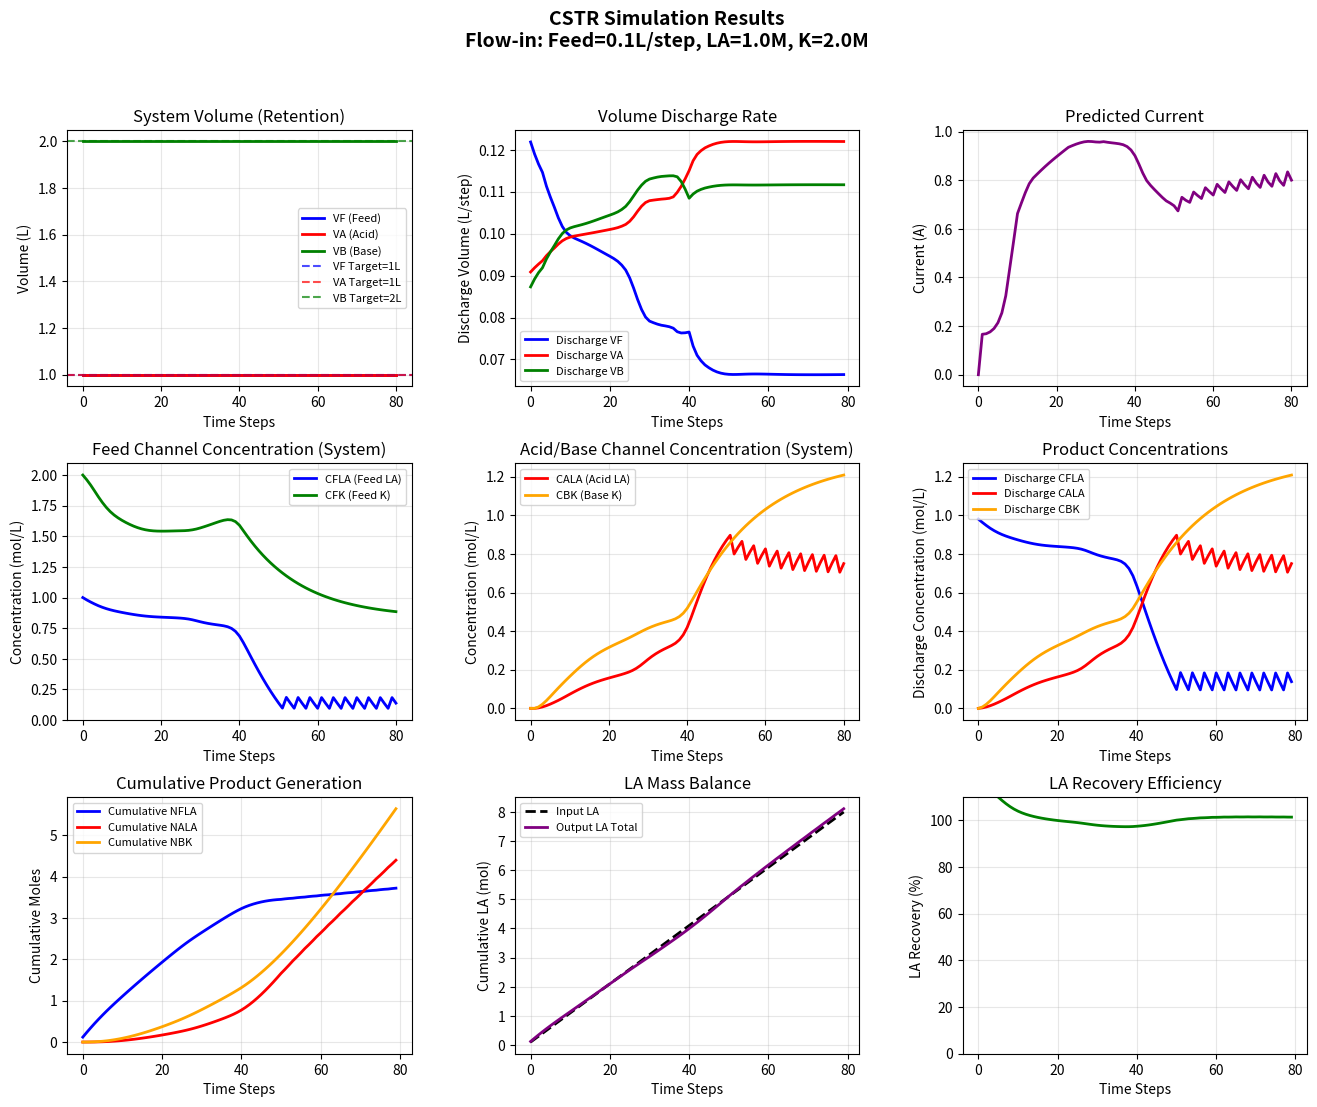

🎯 CSTR 성능 요약:
   💧 최종 상태 - VF: 1.000L, VA: 1.000L, VB: 2.000L
   🔄 평균 유출량 - VF: 0.0804L/step, VA: 0.1117L/step
   ⚡ 평균 전류: 0.752A
   📈 누적 LA 생산: 4.394mol (Feed에서 Acid로 이동)
   🎯 최종 LA 회수율: 101.40%


In [15]:
# CSTR 결과 시각화: 시스템 내 잔류량 + Discharge 흐름
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Volume 변화 (시스템 내 잔류량)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(sim_res['time'], sim_res['VF'], 'b-', label='VF (Feed)', linewidth=2)
ax1.plot(sim_res['time'], sim_res['VA'], 'r-', label='VA (Acid)', linewidth=2) 
ax1.plot(sim_res['time'], sim_res['VB'], 'g-', label='VB (Base)', linewidth=2)
ax1.axhline(y=VF, color='b', linestyle='--', alpha=0.7, label=f'VF Target={VF}L')
ax1.axhline(y=VA, color='r', linestyle='--', alpha=0.7, label=f'VA Target={VA}L')
ax1.axhline(y=VB, color='g', linestyle='--', alpha=0.7, label=f'VB Target={VB}L')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Volume (L)')
ax1.set_title('System Volume (Retention)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Discharge Volumes
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(discharge_data['time'], discharge_data['discharge_VF'], 'b-', label='Discharge VF', linewidth=2)
ax2.plot(discharge_data['time'], discharge_data['discharge_VA'], 'r-', label='Discharge VA', linewidth=2)
ax2.plot(discharge_data['time'], discharge_data['discharge_VB'], 'g-', label='Discharge VB', linewidth=2)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Discharge Volume (L/step)')
ax2.set_title('Volume Discharge Rate')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Current
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(sim_res['time'], sim_res['I'], 'purple', linewidth=2)
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Current (A)')
ax3.set_title('Predicted Current')
ax3.grid(True, alpha=0.3)

# 4. Feed Channel 농도 (시스템 내)
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sim_res['time'], sim_res['CFLA'], 'b-', label='CFLA (Feed LA)', linewidth=2)
ax4.plot(sim_res['time'], sim_res['CFK'], 'g-', label='CFK (Feed K)', linewidth=2)
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('Concentration (mol/L)')
ax4.set_title('Feed Channel Concentration (System)')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Acid/Base Channel 농도 (시스템 내)  
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(sim_res['time'], sim_res['CALA'], 'r-', label='CALA (Acid LA)', linewidth=2)
ax5.plot(sim_res['time'], sim_res['CBK'], 'orange', label='CBK (Base K)', linewidth=2)
ax5.set_xlabel('Time Steps')
ax5.set_ylabel('Concentration (mol/L)')
ax5.set_title('Acid/Base Channel Concentration (System)')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Discharge 농도
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(discharge_data['time'], discharge_data['discharge_CFLA'], 'b-', label='Discharge CFLA', linewidth=2)
ax6.plot(discharge_data['time'], discharge_data['discharge_CALA'], 'r-', label='Discharge CALA', linewidth=2)
ax6.plot(discharge_data['time'], discharge_data['discharge_CBK'], 'orange', label='Discharge CBK', linewidth=2)
ax6.set_xlabel('Time Steps')
ax6.set_ylabel('Discharge Concentration (mol/L)')
ax6.set_title('Product Concentrations')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# 7. 누적 Production (Discharge 적분)
ax7 = fig.add_subplot(gs[2, 0])
cum_NFLA = np.cumsum(discharge_data['discharge_NFLA'])
cum_NALA = np.cumsum(discharge_data['discharge_NALA'])
cum_NBK = np.cumsum(discharge_data['discharge_NBK'])
ax7.plot(discharge_data['time'], cum_NFLA, 'b-', label='Cumulative NFLA', linewidth=2)
ax7.plot(discharge_data['time'], cum_NALA, 'r-', label='Cumulative NALA', linewidth=2)
ax7.plot(discharge_data['time'], cum_NBK, 'orange', label='Cumulative NBK', linewidth=2)
ax7.set_xlabel('Time Steps')
ax7.set_ylabel('Cumulative Moles')
ax7.set_title('Cumulative Product Generation')
ax7.legend(fontsize=8)
ax7.grid(True, alpha=0.3)

# 8. Mass Balance Check
ax8 = fig.add_subplot(gs[2, 1])
# LA 입력량 vs 출력량
input_LA_rate = flow_in[0] * flow_in[3]  # mol/step
cum_input_LA = np.cumsum([input_LA_rate] * len(discharge_data['time']))
ax8.plot(discharge_data['time'], cum_input_LA, 'k--', label='Input LA', linewidth=2)
ax8.plot(discharge_data['time'], cum_NFLA + cum_NALA, 'purple', label='Output LA Total', linewidth=2)
ax8.set_xlabel('Time Steps')
ax8.set_ylabel('Cumulative LA (mol)')
ax8.set_title('LA Mass Balance')
ax8.legend(fontsize=8)
ax8.grid(True, alpha=0.3)

# 9. Recovery Efficiency
ax9 = fig.add_subplot(gs[2, 2])
if len(cum_input_LA) > 0 and cum_input_LA[-1] > 0:
    recovery_efficiency = (cum_NFLA + cum_NALA) / cum_input_LA * 100
    ax9.plot(discharge_data['time'], recovery_efficiency, 'green', linewidth=2)
    ax9.set_xlabel('Time Steps')
    ax9.set_ylabel('LA Recovery (%)')
    ax9.set_title('LA Recovery Efficiency')
    ax9.grid(True, alpha=0.3)
    ax9.set_ylim(0, 110)

plt.suptitle(f'CSTR Simulation Results\nFlow-in: Feed={flow_in[0]}L/step, LA={flow_in[3]}M, K={flow_in[4]}M', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("🎯 CSTR 성능 요약:")
print(f"   💧 최종 상태 - VF: {sim_res['VF'][-1]:.3f}L, VA: {sim_res['VA'][-1]:.3f}L, VB: {sim_res['VB'][-1]:.3f}L")
print(f"   🔄 평균 유출량 - VF: {np.mean(discharge_data['discharge_VF']):.4f}L/step, VA: {np.mean(discharge_data['discharge_VA']):.4f}L/step")
print(f"   ⚡ 평균 전류: {np.mean(sim_res['I']):.3f}A")
print(f"   📈 누적 LA 생산: {cum_NALA[-1]:.3f}mol (Feed에서 Acid로 이동)")
if len(cum_input_LA) > 0 and cum_input_LA[-1] > 0:
    final_recovery = recovery_efficiency[-1]
    print(f"   🎯 최종 LA 회수율: {final_recovery:.2f}%")

In [16]:
# CSTR 성능 평가 함수 (steady-state 기준)
def cstr_performance(sim_res, discharge_data, flow_in, operating_conditions):
    """
    CSTR 성능 평가 - steady state 및 discharge 기반
    Args:
        sim_res: 시스템 잔류량 시뮬레이션 결과
        discharge_data: discharge 데이터  
        flow_in: [Feed_flow, Acid_flow, Base_flow, Feed_LA_conc, Feed_K_conc]
        operating_conditions: [V, E, target_conc]
    Returns:
        performance_metrics: DataFrame with performance metrics
    """
    V, E, target_conc = operating_conditions
    F_feed, F_acid, F_base, C_feed_LA, C_feed_K = flow_in
    
    Amem = 0.055  # m2
    MwLA = 90.1   # g/mol
    
    # Steady-state 구간 선택 (후반 20% 구간)
    steady_start = int(len(discharge_data['time']) * 0.8)
    
    # Steady-state 평균값들
    avg_discharge_VA = np.mean(discharge_data['discharge_VA'][steady_start:])
    avg_discharge_CALA = np.mean(discharge_data['discharge_CALA'][steady_start:])  
    avg_discharge_NALA = np.mean(discharge_data['discharge_NALA'][steady_start:])
    avg_current = np.mean(sim_res['I'][steady_start:])
    
    # 생산성 계산
    LA_production_rate = avg_discharge_NALA  # mol/time_step
    LA_production_rate_g_hr = LA_production_rate * MwLA * 3600 / 900  # g/hr (assuming 900s/time_step)
    
    # 에너지 소모량 계산 (1kg LA 생산 기준)
    if LA_production_rate_g_hr > 0:
        time_for_1kg = 1000 / LA_production_rate_g_hr  # hr
        
        # 에너지 계산
        E_BMED = V * avg_current * time_for_1kg / 1000  # kWh/kg
        E_PUMP = 0.0047 * time_for_1kg  # kWh/kg (펌프 에너지)
        E_sensible = avg_discharge_VA * 4.184 * (100-20) * time_for_1kg / 3600  # kWh/kg (가열)
        
        # 농축을 위한 증발 에너지 (target_conc 농도까지)
        if avg_discharge_CALA > 0 and target_conc > avg_discharge_CALA:
            target_VA = avg_discharge_NALA * MwLA / 1000 / target_conc  # L
            E_vapor = (avg_discharge_VA - target_VA) * 44/18 * time_for_1kg / 3600  # kWh/kg
        else:
            E_vapor = 0
            
        Total_E = E_BMED + E_PUMP + E_sensible + E_vapor
    else:
        time_for_1kg = E_BMED = E_PUMP = E_sensible = E_vapor = Total_E = 0
    
    # 회수율 계산
    input_LA_rate = F_feed * C_feed_LA  # mol/time_step
    LA_recovery = (LA_production_rate / input_LA_rate) * 100 if input_LA_rate > 0 else 0
    
    # 농도 향상 계산
    conc_enhancement = avg_discharge_CALA / C_feed_LA if C_feed_LA > 0 else 0
    
    # 결과 DataFrame
    results_df = pd.DataFrame({
        'Voltage (V)': [V],
        'Electrolyte (M)': [E], 
        'Feed Flow (L/step)': [F_feed],
        'Acid Flow (L/step)': [F_acid],
        'Base Flow (L/step)': [F_base],
        'Feed LA (M)': [C_feed_LA],
        'Feed K (M)': [C_feed_K],
        'Production Rate (g/hr)': [LA_production_rate_g_hr],
        'Product Conc (M)': [avg_discharge_CALA],
        'LA Recovery (%)': [LA_recovery],
        'Conc Enhancement': [conc_enhancement],
        'Avg Current (A)': [avg_current],
        'E Stack (kWh/kg)': [E_BMED],
        'E PUMP (kWh/kg)': [E_PUMP],
        'E Sensible (kWh/kg)': [E_sensible],
        'E Vapor (kWh/kg)': [E_vapor],
        'Total (kWh/kg)': [Total_E],
        'Operation Time (hr/kg)': [time_for_1kg]
    })
    
    return results_df

# 성능 평가 실행
operating_conditions = [V, E, 0.85]  # V, E, target_concentration
performance_df = cstr_performance(sim_res, discharge_data, flow_in, operating_conditions)

print("🎯 CSTR 성능 평가 결과:")
print("="*80)
performance_df

🎯 CSTR 성능 평가 결과:


,Voltage (V),Electrolyte (M),Feed Flow (L/step),Acid Flow (L/step),Base Flow (L/step),Feed LA (M),Feed K (M),Production Rate (g/hr),Product Conc (M),LA Recovery (%),Conc Enhancement,Avg Current (A),E Stack (kWh/kg),E PUMP (kWh/kg),E Sensible (kWh/kg),E Vapor (kWh/kg),Total (kWh/kg),Operation Time (hr/kg)
0,20,0.25,0.1,0.1,0.1,1.0,2.0,33.211241,0.755475,92.151057,0.755475,0.792497,0.477246,0.141518,0.341487,0.002294,0.962546,30.110287
